In [27]:
# Import
import utils
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt
import ps_utils
import pickle

import menpo3d
import trimesh
import menpo
from menpo3d.correspond import nicp
from menpo3d import io
from menpo.model import PCAModel
from plyfile import PlyData, PlyElement
from scipy.ndimage.filters import gaussian_filter

landmark_nose_tip = 30

pixel_per_meter = 10296.3 
ipad_height_pixel = 3088.
ipad_width_pixel = 2316.
depth_width = 480
depth_height = 640

Text(0.5, 1.0, 'mask')

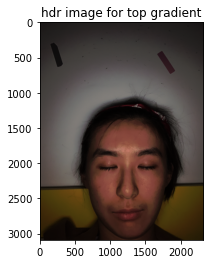

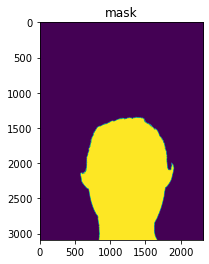

In [2]:
# Data Loading
base_addr = '/Users/tianyizuo/Desktop/Captures/half/'
up_side_down = False

def load_folder(addr):
    mask = utils.get_heic(addr +'mask.HEIC')
    mask = np.rot90(mask, 1)
    mask = mask.repeat(2, axis=0).repeat(2, axis=1) #upsample
    mask = mask.mean(axis=-1)
    mask = (mask > 100).astype(int).astype(np.float32)
    return {
        'depth': pandas.read_csv(addr+'depth.txt', header=None),
        'up': utils.get_hdr_image(addr + 'up'),
        'down': utils.get_hdr_image(addr + 'down'),
        'left': utils.get_hdr_image(addr + 'left'),
        'right': utils.get_hdr_image(addr + 'right'),
        'full': utils.get_hdr_image(addr + 'full'),
        'color1': utils.get_hdr_image(addr + 'color1'),
        'color2': utils.get_hdr_image(addr + 'color2'),
        'mask': mask
    }

all_data = {
    'mid': load_folder(base_addr + "mid/"),
#     'toleft': load_folder(base_addr + "toleft/"),
#     'toright': load_folder(base_addr + "toright/"),
}

plt.figure()
plt.imshow(all_data['mid']['up'])
plt.title("hdr image for top gradient")

plt.figure()
plt.imshow(all_data['mid']['mask'])
plt.title("mask")


In [3]:
# example of creating .obj files
texturePaths = [base_addr+"mid/full0.HEIC"] #, base_addr+"toleft/full0.jpg", base_addr+"toright/full0.jpg"]
mtlPaths = ['./out/mid.mtl'] #, './out/toleft.mtl', './out/toright.mtl']
objPaths = ['./out/mid.obj']#, './out/toleft.obj', './out/toright.obj']
pickedPointsPaths =  ['./out/mid.pp']#, './out/toleft.pp', './out/toright.pp']
matNames = ['mid']#, 'toleft', 'toright']
masks = [all_data['mid']['mask']]#, all_data['toleft']['mask'], all_data['toright']['mask']]
depths = [all_data['mid']['depth']]#, all_data['toleft']['depth'], all_data['toright']['depth']]

landmark_3 = []
points_3 = []
ids_3 = []
location_3 = []
location_no_smooth_3 = []
ibug_3 = []
normal_3 = []

for i in range(len(texturePaths)):
    l, p, ids, location, ibug, normal, ls_ns = utils.landmark_one_object(texturePaths[i], mtlPaths[i], depths[i], objPaths[i], 
                        masks[i], pickedPointsPaths[i], matNames[i], up_side_down = up_side_down)
    landmark_3.append(l)
    points_3.append(p)
    ids_3.append(ids)
    location_3.append(location)
    ibug_3.append(ibug)
    normal_3.append(normal)
    location_no_smooth_3.append(ls_ns)


In [4]:
# points_merge = [points_3[0].copy(), points_3[2].copy()]
# locations_merge = [location_3[0].copy(), location_3[2].copy()]
# ids_merge = [ids_3[0].copy(), ids_3[2].copy()]
# matNames_merge = ["mid", "right"]
# texturePaths_merge =  [texturePaths[0], texturePaths[2]]
# a = utils.affine_object(points_3[2], points_3[0], location_3[2], "./out/affine_2_to_0.obj", ids_3[2])
# b = utils.merge_object("./out/merge_0_2_ibug51.obj",  "./out/mid_right.mtl", points_merge, locations_merge, ids_merge, matNames_merge, texturePaths_merge)
# # b = merge_object("./out/merge_0_2_ibug51.obj",  "./out/mid_right.mtl", points_3, location_3, ids_3, matNames, texturePaths)

In [5]:
# ids_right_masked = utils.mask_half_face(ibug_3[2], ids)
# ids_merge_masked = [ids_3[0], ids_right_masked]
# utils.merge_object("./out/merge_0_2_ibug51_half.obj",  "./out/mid_right_half.mtl", points_merge, locations_merge, ids_merge_masked, matNames_merge, texturePaths_merge)

In [6]:
I, size = utils.get_input(all_data['mid'])
normal_depth = normal_3[0]


(7151808, 4)


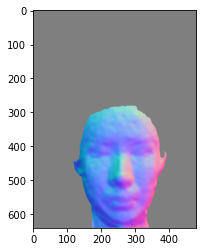

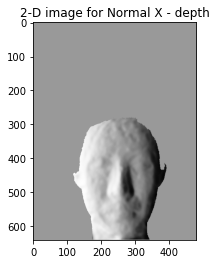

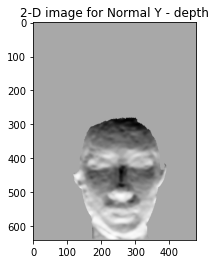

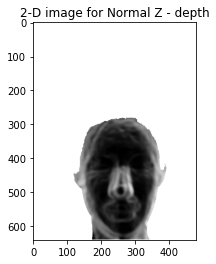

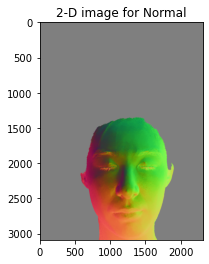

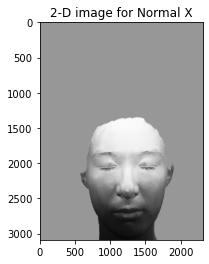

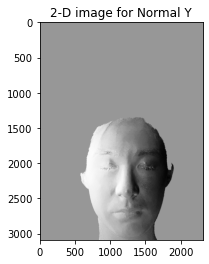

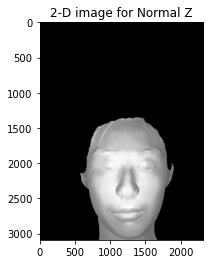

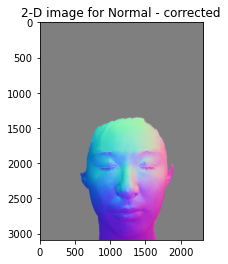

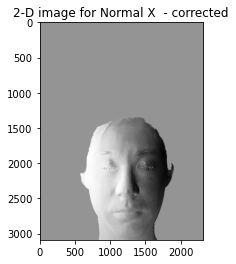

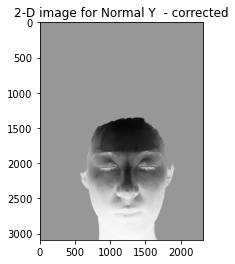

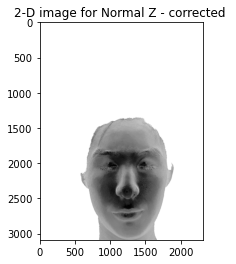

In [7]:
normal_corrected = utils.surface_normal_correction(I, size, all_data['mid']['mask'], normal_depth)

In [8]:
# displacement_map = ps_utils.get_surface(normal_corrected, 'average')
# displacement_map = ps_utils.find_surface(normal_corrected, size, displacement_map)
# mlab.surf(displacement_map)
# mlab.show()
# displacement_map = ps_utils.unbiased_integrate(normal_corrected[:, :, 0], normal_corrected[:, :, 1], normal_corrected[:, :, 2], all_data['mid']['mask'])

In [9]:
# bump_object("./out/mid_bumped.obj", "./out/mid_bumped.mtl", location_3[0].copy(), "mid_bumped", texturePaths[0], displacement_map.copy(), mask.copy())

In [10]:
# pickle.dump(displacement_map, open('./displacement_map.p', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

(7151808, 4)


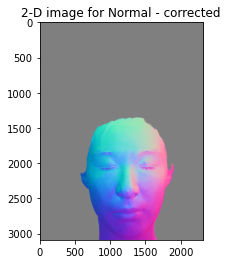

(7151808, 4)


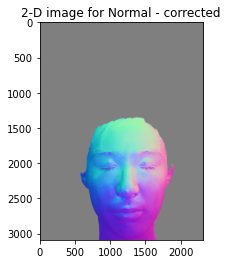

(7151808, 4)


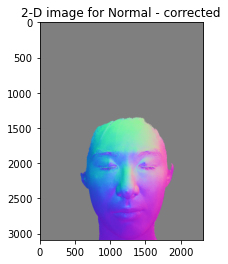

(7151808, 4)


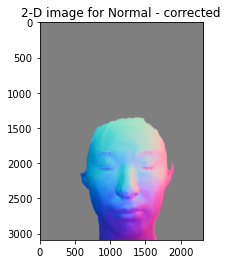

In [44]:
# variation of svds:
I_red, size_red = utils.get_input(all_data['mid'], "R")
I_green, size_green = utils.get_input(all_data['mid'], "G")
I_blue, size_blue = utils.get_input(all_data['mid'], "B")

normal_red = utils.surface_normal_correction(I_red, size_red, all_data['mid']['mask'], normal_depth, False)
normal_green = utils.surface_normal_correction(I_green, size_green, all_data['mid']['mask'], normal_depth, False)
normal_blue = utils.surface_normal_correction(I_blue, size_blue, all_data['mid']['mask'], normal_depth, False)

plt.imsave("./colorspace/normal_red.png", np.clip((normal_red + 1)/2, a_min=0, a_max=1))
plt.imsave("./colorspace/normal_green.png", np.clip((normal_green + 1)/2, a_min=0, a_max=1))
plt.imsave("./colorspace/normal_blue.png", np.clip((normal_blue + 1)/2, a_min=0, a_max=1))


normal_standard = utils.surface_normal_correction(I_red - 0.8 * I_blue, size_blue, all_data['mid']['mask'], normal_depth, False)
plt.imsave("./colorspace/normal_R-0.8B.png", np.clip((normal_standard + 1)/2, a_min=0, a_max=1))
        

In [12]:
#Create plyfile for optimisation
w = 480
h = 640
color = np.clip(cv2.resize(all_data['mid']['full'].copy(), dsize=(w, h)) * 255., 0, 255).astype(int)
normal_c = - normal_red
size = (h - 1) * 2 * (w - 1)
color = np.repeat(color[:-1, :-1], 2, axis=0).reshape((size, 3)) 
location_mid = cv2.resize(location_no_smooth_3[0].copy().astype('float32'), dsize=(w, h))
normal_mid = cv2.resize(normal_c.astype('float32'), dsize=(w, h))
normal_mid = normal_mid.reshape(h * w, 3)
vertex = location_mid.reshape(h * w, 3)
vertex = np.asarray(list(zip(vertex[:,0], vertex[:,1], vertex[:,2], normal_mid[:, 0], normal_mid[:, 1], normal_mid[:, 2]))).flatten()
vertex.dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('nx', 'f4'), ('ny', 'f4'), ('nz', 'f4')]



face_id = np.zeros(((h - 1) * 2, w - 1, 3), dtype=int)
for i in range(h - 1):
    for j in range(w - 1):
        v1 = int(i * w + j)
        v2 = int((i + 1) * w + j)
        v3 = int(i * w + j + 1)
        v4 = int((i + 1) * w + j + 1)
        face_id[i * 2, j, :3] = np.asarray([(v2, v1, v3)])
        face_id[i * 2 + 1, j, :3] = np.asarray([(v2, v3, v4)])
face_id = face_id.reshape(size, 3).astype(int)
face = np.zeros(size, dtype=[('vertex_indices', 'i4', (3,)),
                          ('red', 'u1'), ('green', 'u1'),
                          ('blue', 'u1')])
for i in range(size):
    face[i] = ([face_id[i, 0], face_id[i, 1], face_id[i, 2]], color[i, 0], color[i, 1], color[i, 2])


In [13]:
plydata = PlyData(
                [
                    PlyElement.describe(
                        vertex, 'vertex'
                    )
                    ,
                    PlyElement.describe(face, 'face')
                ],
                text=False, byte_order='>'
            )
plydata.write("./mid.ply")

0.7103761


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


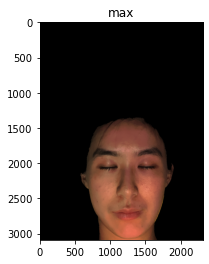

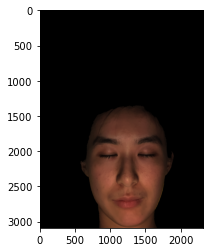

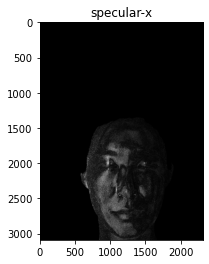

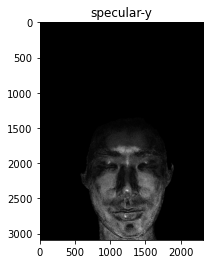

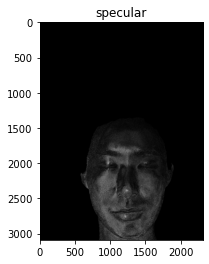

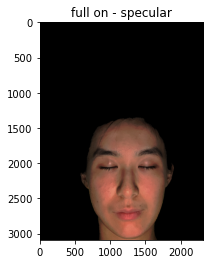

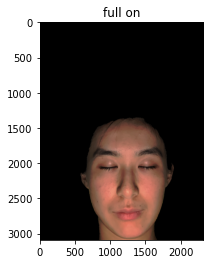

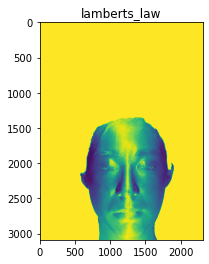

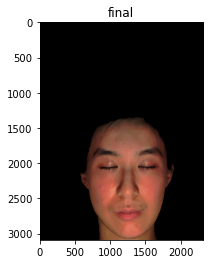

In [41]:
mask_3 = np.stack([all_data['mid']['mask'], all_data['mid']['mask'], all_data['mid']['mask']], axis = 2)
down = np.clip(all_data['mid']['down'] * mask_3, 0, 1)
up = np.clip(all_data['mid']['up'] * mask_3, 0, 1)
left = np.clip(all_data['mid']['left'] * mask_3, 0, 1)
right = np.clip(all_data['mid']['right'] * mask_3, 0, 1)
full = np.clip(all_data['mid']['full'] * mask_3, 0, 1)

all_pics = np.stack([down, up, left, right], axis=-1)
max_all = all_pics.max(axis=-1)
min_all = all_pics.mean(axis=-1)
ambient = min_all[mask.astype(bool)].mean()/max_all[mask.astype(bool)].mean()
print(ambient)
plt.figure()
plt.imshow(max_all, cmap = "gray")
plt.title("max")

plt.figure()
plt.imshow(min_all, cmap = "gray")

    
rgbs = [down, up, left, right]
hsvs = []
for rgb in rgbs:
    hsvs.append(cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV))
chromas = []
for rgb in rgbs:
    M = np.max(rgb, axis=2)
    m = np.min(rgb, axis=2)
    chromas.append(M-m)
y, y_, x, x_ = hsvs
ychroma, ychroma_, xchroma, xchroma_ = chromas
eps = 1e-3
delta_y = y[:, :, 2] - ychroma/(y_[:, :, 1] + eps)
delta_x = x[:, :, 2] - xchroma/(x_[:, :, 1] + eps)

specular_x = np.abs(delta_x)
specular_y = np.abs(delta_y)

def visualize_specular_albedo(specular):
    return (utils.min_max_normalization(specular.clip(0, 0.2) * 5)).astype(np.float32)

plt.figure()
plt.imshow(visualize_specular_albedo(specular_x), cmap = "gray")
plt.title("specular-x")
plt.savefig('specular-x-corrected.png')

plt.figure()
plt.imshow(visualize_specular_albedo(specular_y), cmap = "gray")
plt.title("specular-y")
plt.savefig('specular-y-corrected.png')

total_specular = (specular_x + specular_y)/2
plt.figure()
plt.imshow(visualize_specular_albedo(total_specular), cmap = "gray")
plt.title("specular")
plt.savefig('specular-corrected.png')
speculars = np.stack([total_specular] * 3, axis = 2)


where_are_NaNs = np.isnan(speculars)
speculars[where_are_NaNs] = 0
where_are_infs = np.isposinf(speculars)
speculars[where_are_infs] = 1
where_are_neginfs = np.isneginf(speculars)
speculars[where_are_neginfs] = 0

diffuse_albedo = full - speculars

plt.figure()
plt.imshow(diffuse_albedo)
plt.title("full on - specular")

pickle.dump(diffuse_albedo, open('./albedo.p', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

plt.figure()
plt.imshow(full)
plt.title("full on")

diffuse_albedo_corrected = diffuse_albedo.copy()
normal = normal_corrected #cv2.resize(normal_depth.copy(), dsize=(diffuse_albedo.shape[1], diffuse_albedo.shape[0]))
illumination = np.asarray([1., 0., 0.])
lamberts_law = 1 - np.abs(np.clip(np.dot(normal, illumination), -1.0, 1.0))


plt.figure()
plt.imshow(lamberts_law)
plt.title("lamberts_law")
plt.imsave("./shadow_remove/diffuse_albedo.png",  np.clip(diffuse_albedo, 0, 1))
diffuse_albedo_corrected_hsv = cv2.cvtColor(diffuse_albedo_corrected, cv2.COLOR_RGB2HSV)
diffuse_albedo_corrected_hsv[:, :, 1:] /= np.stack([lamberts_law, lamberts_law], axis = -1)
diffuse_albedo_corrected_hsv = cv2.cvtColor(diffuse_albedo_corrected_hsv, cv2.COLOR_HSV2RGB)
# diffuse_albedo_corrected /= np.stack([lamberts_law, lamberts_law, lamberts_law], axis = -1)
plt.imsave("./shadow_remove/divide_by_lambert.png",  np.clip(diffuse_albedo_corrected, 0, 1))
alpha = 0.1
diffuse_albedo_corrected = alpha *  np.clip(diffuse_albedo_corrected_hsv, 0, 1) + diffuse_albedo * (1 - alpha)

plt.figure()
plt.imshow(diffuse_albedo_corrected)
plt.title("final")
plt.imsave("./shadow_remove/final.png", np.clip(diffuse_albedo_corrected, 0, 1))
        
plt.show()

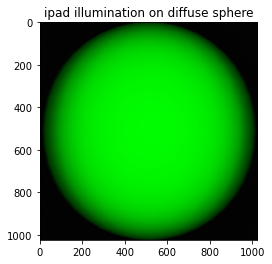

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


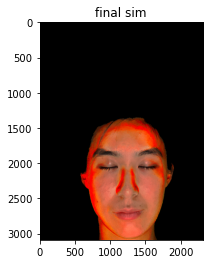

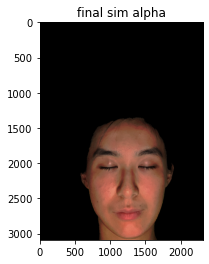

In [42]:
mask = all_data['mid']['mask']
normal = np.clip(normal.copy(), -1, 1) + 1e-3
diffuse_albedo_corrected_sim = diffuse_albedo.copy()
illu = utils.min_max_normalization(cv2.imread('./illu.jpg'))
plt.figure()
plt.imshow(illu)
plt.title("ipad illumination on diffuse sphere")
plt.show()

length = illu.shape[0] - 1
diffuse_albedo_corrected_sim = cv2.cvtColor(diffuse_albedo_corrected_sim, cv2.COLOR_RGB2HSV)
for i in range(3088):
    for j in range(2316):
        if mask[i, j] > 0:
            n = normal[i, j]
            diffuse_albedo_corrected_sim[i, j, 1:] /= illu[int((n[1] + 1)/2 * length), 
                                                       int((n[0] + 1)/2 * length)].max()
diffuse_albedo_corrected_sim = cv2.cvtColor(diffuse_albedo_corrected_sim, cv2.COLOR_HSV2RGB)
            
plt.figure()
plt.imshow(diffuse_albedo_corrected_sim)
plt.title("final sim")
plt.imsave("./shadow_remove/final_sim.png", np.clip(diffuse_albedo_corrected_sim, 0, 1))

# diffuse_albedo_corrected_sim /= np.stack([lamberts_law, lamberts_law, lamberts_law], axis = -1)
alpha = 0.1
diffuse_albedo_corrected_sim = alpha *  np.clip(diffuse_albedo_corrected_sim, 0, 1) + diffuse_albedo * (1 - alpha)

plt.figure()
plt.imshow(diffuse_albedo_corrected_sim)
plt.title("final sim alpha")
plt.imsave("./shadow_remove/final_sim.png", np.clip(diffuse_albedo_corrected_sim, 0, 1))
plt.show()

In [16]:
# s, g = utils.get_specular_and_matt(all_data['mid']['full'], all_data['mid']['mask'])

In [17]:
# Nuv = utils.normal_from_uv(all_data['mid'], normal_depth)

In [18]:
# plt.imsave("./colorspace/hdr.png", np.clip((Nuv + 1)/2, a_min=0, a_max=1))

0.9104089


<ipython-input-43-ffdba9fc1c36>:9: RuntimeWarning: invalid value encountered in true_divide
  r_spec /= np.linalg.norm(r_spec, axis = -1).reshape(r_spec.shape[0], r_spec.shape[1], 1)


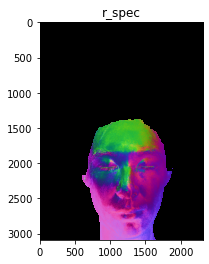

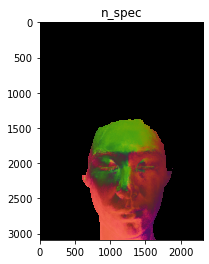

In [43]:
# Specular normal
masked_diffuse = diffuse_albedo[all_data['mid']['mask'].astype(bool)]
masked_full = full[all_data['mid']['mask'].astype(bool)]
alpha = np.divide(masked_diffuse, masked_full).mean()

print(alpha)

r_spec = normal_blue - alpha * normal_standard
r_spec /= np.linalg.norm(r_spec, axis = -1).reshape(r_spec.shape[0], r_spec.shape[1], 1)

viewing_direction = np.asarray([0, 0, -1]) # how to find this v ?

n_spec = r_spec + viewing_direction
n_spec /= np.linalg.norm(n_spec, axis = -1).reshape(n_spec.shape[0], n_spec.shape[1], 1)

plt.figure()
plt.imshow((r_spec + 1)/ 2)
plt.imsave("./normals/r_spec.png", (r_spec + 1)/ 2, cmap = "gray")
plt.title("r_spec")

plt.figure()
plt.imshow((n_spec + 1)/ 2)
plt.imsave("./normals/n_spec.png", (n_spec + 1)/ 2, cmap = "gray")
plt.title("n_spec")

plt.show()

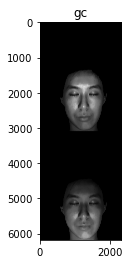

gc (6176, 2316)
A (6176, 2317)


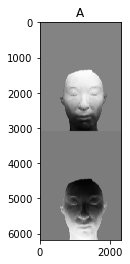

ds (2317, 2316)


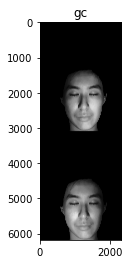

gc (6176, 2316)
A (6176, 2317)


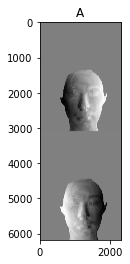

ds (2317, 2316)
(2317, 2316)


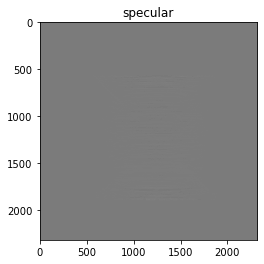

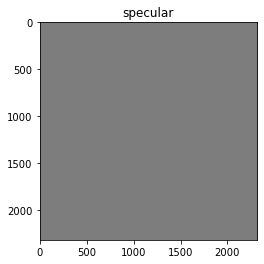

In [20]:
#Equation. 7. No color for the X axis. blue for horizontal and red for vertical
blurred_normal = normal_standard.copy()
g_x = all_data['mid']['color1'][:, :, 2] * mask.astype(float)
c_x = all_data['mid']['color2'][:, :, 2] * mask.astype(float)
Nd_x = utils.min_max_normalization(blurred_normal[:, :, 1])

c_y = all_data['mid']['color2'][:, :, 0] * mask.astype(float)
g_y = all_data['mid']['color1'][:, :, 0] * mask.astype(float)
Nd_y = utils.min_max_normalization(blurred_normal[:, :, 0])


def solve_spectral(G, C, Nd):
    gc = np.append(G, C, axis = 0)
    plt.figure()
    plt.imshow(gc, cmap = "gray")
    plt.title("gc")
    plt.show()
    print("gc", gc.shape)
    Nd1 = np.append(Nd, np.ones((Nd.shape[0], 1), dtype=float), axis=1)
    Nd0 = np.append((1 - Nd), np.zeros((Nd.shape[0], 1), dtype=float), axis=1)
    A = np.append(Nd1, Nd0, axis=0)
    print("A", A.shape)
    plt.figure()
    plt.imshow(A, cmap = "gray")
    plt.title("A")
    plt.show()
    ds = np.linalg.lstsq(A, gc, rcond=None)[0]
    print("ds", ds.shape)
#     ds = np.matmul(np.linalg.pinv(A),gc)
    return ds


spec_x = solve_spectral(g_x, c_x, Nd_x)
spec_y = solve_spectral(g_y, c_y, Nd_y)
spec_both = (spec_x + spec_y)/2

print(spec_both.shape)

plt.figure()
plt.imshow(spec_x, cmap = "gray")
plt.title("specular")
plt.show()

plt.figure()
plt.imshow(spec_y, cmap = "gray")
plt.title("specular")
plt.show()